In [1]:
import torch, torch.nn.functional as F
import numpy as np
import warnings, random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create vocab
words = open('names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chrs,1)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
stoi, itos

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'})

In [3]:
# create data sets 
block_size = 3

def build_datasets(words):
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
            
    return torch.tensor(x), torch.tensor(y)
            

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_datasets(words[:n1])
Xval, Yval = build_datasets(words[n1:n2])
Xtst, Ytst = build_datasets(words[n2:])

print(f'Training: {Xtr.shape[0]}, Val: {Xval.shape[0]}, Test: {Xtst.shape[0]}') 

Training: 182625, Val: 22655, Test: 22866


In [4]:
# create NN network
g = torch.Generator().manual_seed(2147483647) # for reproducibility

features = 10
hidden_units = 200

# y = b + U*tanh(d+Hx)
C = torch.randn((len(stoi), features), generator=g)
H = torch.randn((features * block_size, hidden_units), generator=g) * (5/3)/((features * block_size)**0.5)# 0.2
# d = torch.randn(hidden_units, generator=g) * 0.01
U = torch.randn((hidden_units,len(stoi)), generator=g) * 0.01
b = torch.randn(len(stoi), generator=g) * 0

bngain = torch.ones((1, hidden_units))
bnbias = torch.zeros((1, hidden_units))
bnmean_running = torch.zeros((1, hidden_units))
bnstd_running = torch.ones((1,hidden_units))

# parameters = [C, H, d, U, b, bngain, bnbias]
parameters = [C, H, U, b, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(f'Total params: {sum(p.nelement() for p in parameters)}')

Total params: 12097


In [5]:
stepi, lossi = [], []

In [6]:
# training
steps = 200000
minibatch_sz = 32

bnmeani, bnstdi = 0, 0
momentum = 0.001

for step in range(steps):    
    #fwd pass
    mb = torch.randint(Xtr.shape[0], (minibatch_sz,), generator=g)
    emb = C[Xtr[mb]].view(Xtr[mb].shape[0], -1)

    # ---- Linear layer 
    hpreact = emb @ H # + d

    # ---- BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():        
        bnmean_running = (1-momentum) * bnmean_running + momentum * bnmeani
        bnstd_running = (1-momentum) * bnstd_running + momentum * bnstdi
    
    # ---- Non-linear layer 
    h = torch.tanh(hpreact)
    
    logits = h @ U + b
    loss = F.cross_entropy(logits, Ytr[mb])
    
    #grad reset, backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #nudge parameters
    lr = 0.1 if step<(steps/2) else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    stepi.append(step)
    lossi.append(loss.log10().item())
    
    if (step % (steps/25)) == 0:
        print(f'Step: {step}, loss: {loss.item():.4f}')
    
    # break  # to study h, hpreact, etc. at init

Step: 0, loss: 3.3239
Step: 8000, loss: 1.8021
Step: 16000, loss: 2.3123
Step: 24000, loss: 2.2889
Step: 32000, loss: 2.3367
Step: 40000, loss: 2.2446
Step: 48000, loss: 2.6371
Step: 56000, loss: 2.0791
Step: 64000, loss: 2.4053
Step: 72000, loss: 2.0395
Step: 80000, loss: 2.2918
Step: 88000, loss: 2.1005
Step: 96000, loss: 1.8575
Step: 104000, loss: 2.0478
Step: 112000, loss: 1.9861
Step: 120000, loss: 1.6413
Step: 128000, loss: 2.0448
Step: 136000, loss: 1.8514
Step: 144000, loss: 1.9088
Step: 152000, loss: 2.2434
Step: 160000, loss: 2.0997
Step: 168000, loss: 1.5514
Step: 176000, loss: 2.2142
Step: 184000, loss: 1.9442
Step: 192000, loss: 2.1493


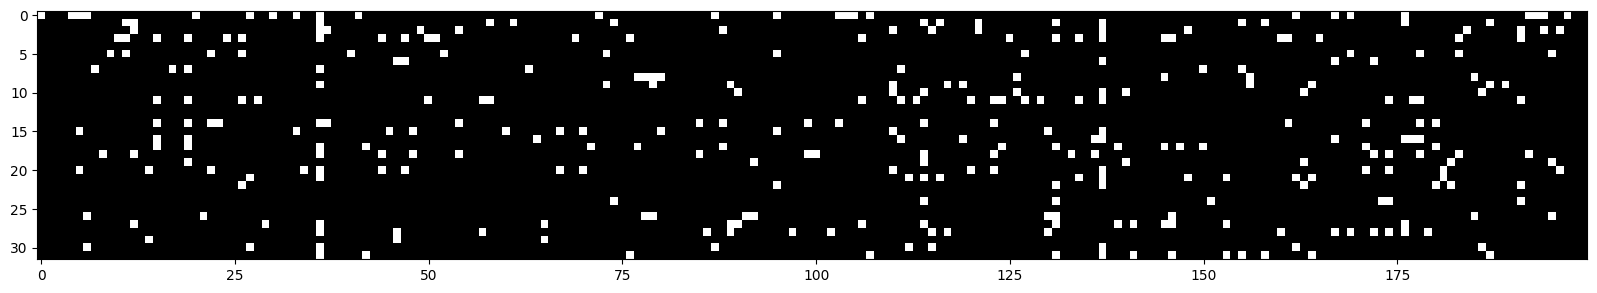

In [7]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

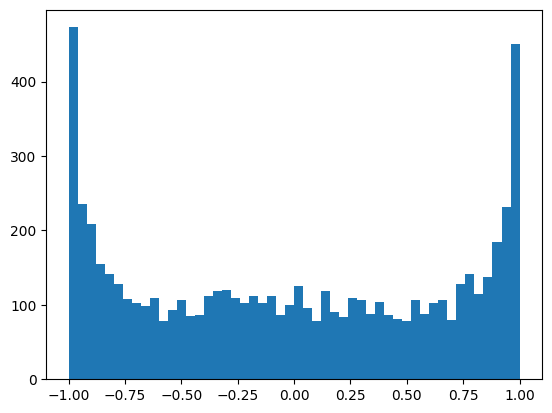

In [8]:
plt.hist(h.view(-1).tolist(), 50);

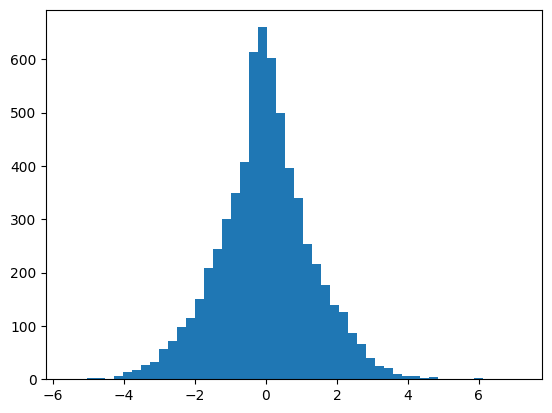

In [9]:
plt.hist(hpreact.view(-1).tolist(), 50);

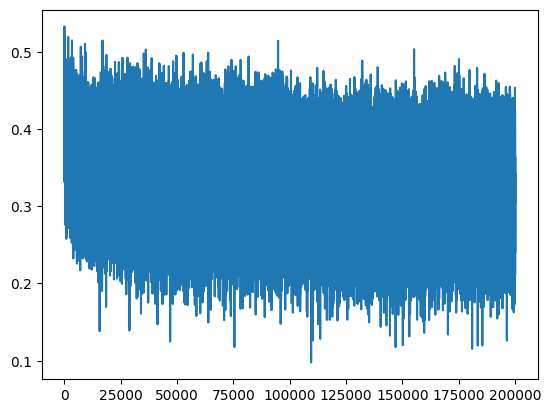

In [10]:
# plot the losses
plt.plot(stepi, lossi)

In [11]:
# Calibrate BN mean and std over entire training set 

with torch.no_grad():
    emb = C[Xtr].view(Xtr.shape[0], -1)
    hpreact = emb @ H # + d
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    
    print(bnmean[0,10:20])
    # print(bnstd)

tensor([-1.8118, -2.7730,  0.0738, -0.6075,  0.4335, -0.6823,  0.7747, -2.1883,
        -0.1999,  1.5907])


In [12]:
print(bnmean_running[0,10:20])

tensor([-1.8295, -2.7717,  0.0714, -0.6182,  0.4336, -0.6687,  0.7706, -2.1880,
        -0.2189,  1.5707])


In [13]:
# check against validation and test sets
@torch.no_grad()
def check_loss(dataset):
    x, y = {'training': (Xtr, Ytr),
            'validation': (Xval, Yval),
            'test': (Xtst, Ytst),
           }[dataset]
    
    emb = C[x].view(x.shape[0], -1)
    hpreact = emb @ H # + d
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ U + b
    loss = F.cross_entropy(logits, y)
    
    print(f'For {dataset} dataset, loss: {loss.item():.4f}')

check_loss('training')
check_loss('validation')
check_loss('test')

For training dataset, loss: 2.0674
For validation dataset, loss: 2.1057
For test dataset, loss: 2.1070


In [14]:
# sampling 
g = torch.Generator().manual_seed(2147483647 + 10) # for reproducibility

@torch.no_grad()
def sample_name():    
    name = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor(context)].view(1, -1)
        hpreact = emb @ H # + d
        # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)

        logits = h @ U + b
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        name.append(itos[ix])
        if ix == 0:
            break
        context = context[1:] + [ix]    
    return name

for _ in range(20):
    print(''.join(sample_name()))

carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.
kiah.
maiivia.
leigh.
ham.
joce.
quint.
salin.
alianni.
wate.
madiaryn.


tensor(-0.0162) tensor(1.0097)
tensor(-0.0016) tensor(0.9913)


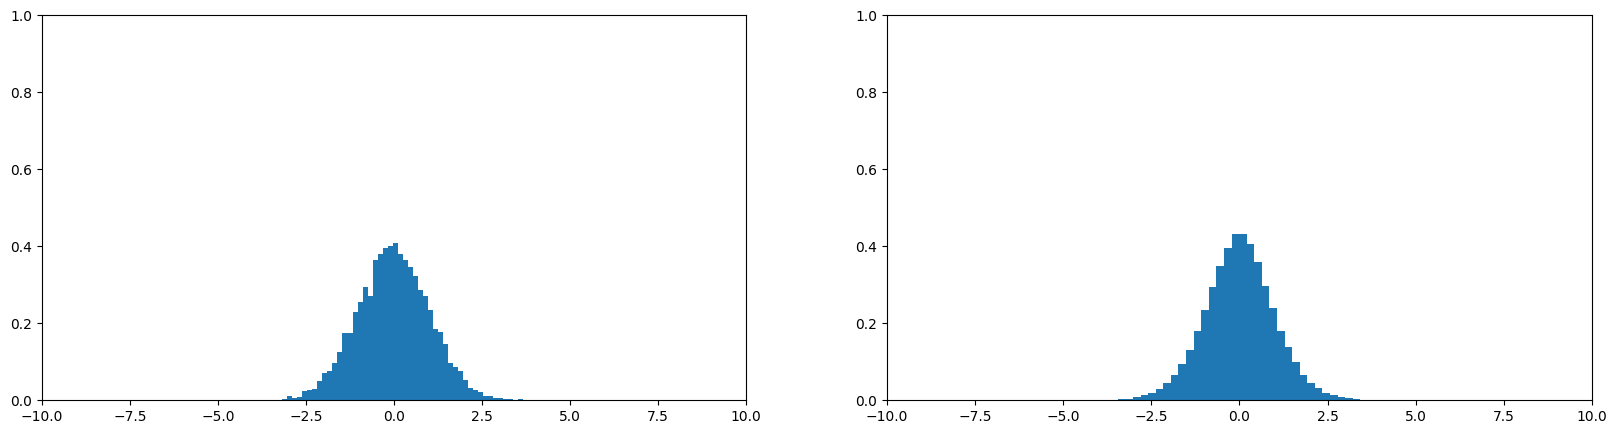

In [15]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.ylim(top=1.0); plt.xlim(-10,10);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);
plt.ylim(top=1.0); plt.xlim(-10,10);

In [45]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=1e-2):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True
        self.bnmean_running = torch.zeros(dim)
        self.bnvar_running = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.bnmean_running
            xvar = self.bnvar_running
                    
        if self.training:
            with torch.no_grad():        
                self.bnmean_running = (1-self.momentum) * self.bnmean_running + self.momentum * xmean
                self.bnvar_running = (1-self.momentum) * self.bnvar_running + self.momentum * xvar

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __init__(self):
        pass
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [46]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
vocab_size = len(stoi)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [47]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

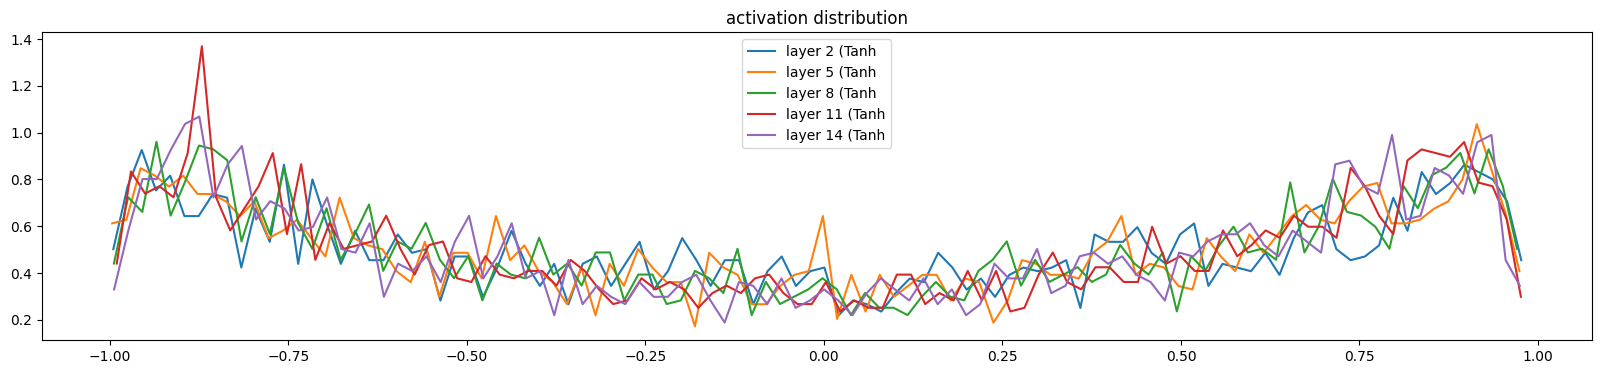

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640701e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045741e-03
layer 11 (      Tanh): mean -0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

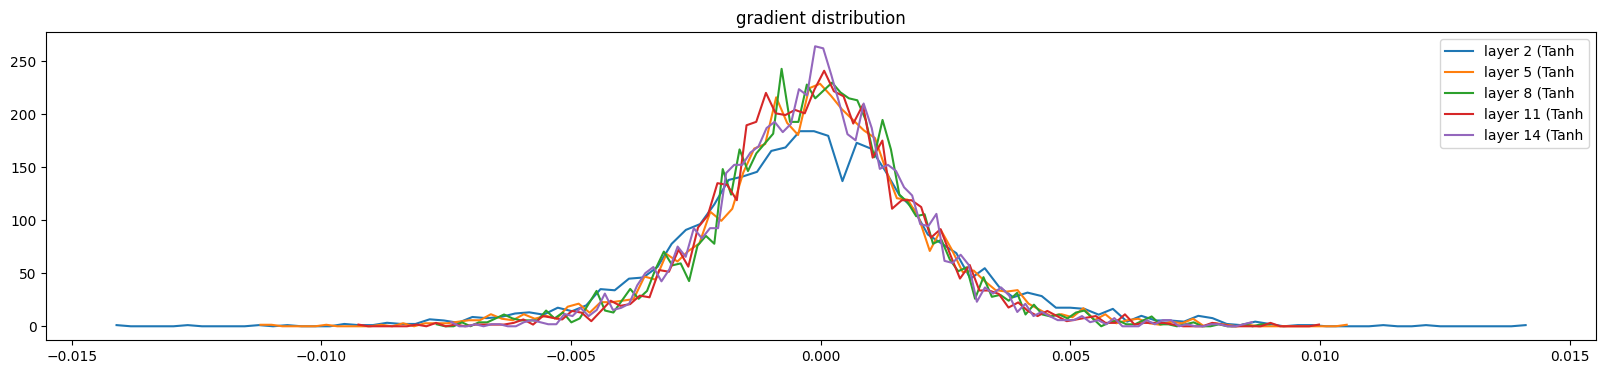

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020535e-03 | grad:data ratio 8.012631e-03
weight  (30, 100) | mean +0.000246 | std 9.241077e-03 | grad:data ratio 4.881091e-02
weight (100, 100) | mean +0.000113 | std 7.132878e-03 | grad:data ratio 6.964618e-02
weight (100, 100) | mean -0.000086 | std 6.234303e-03 | grad:data ratio 6.073739e-02
weight (100, 100) | mean +0.000052 | std 5.742184e-03 | grad:data ratio 5.631480e-02
weight (100, 100) | mean +0.000032 | std 5.672204e-03 | grad:data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160105e-01


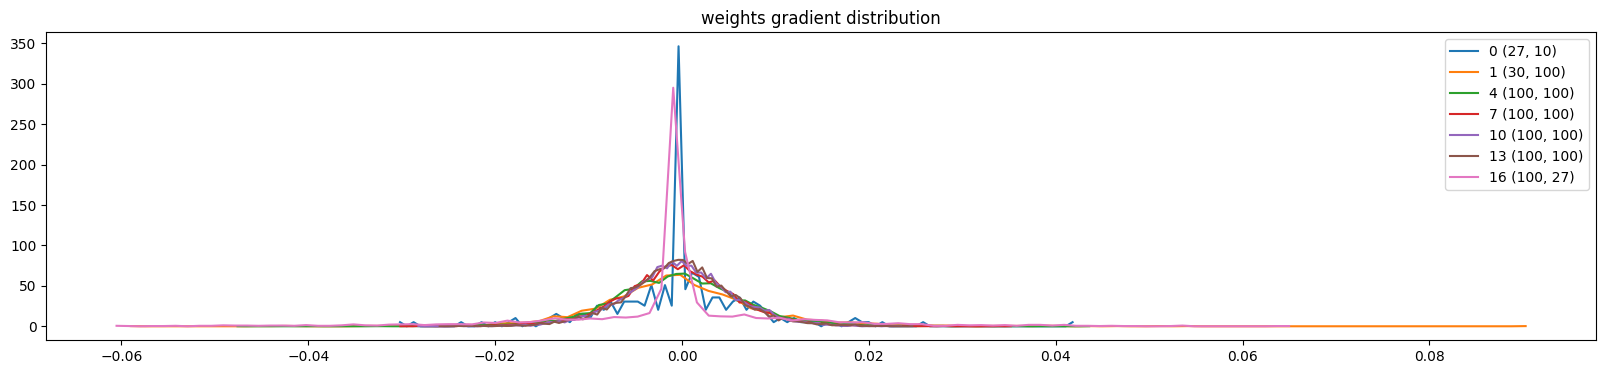

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

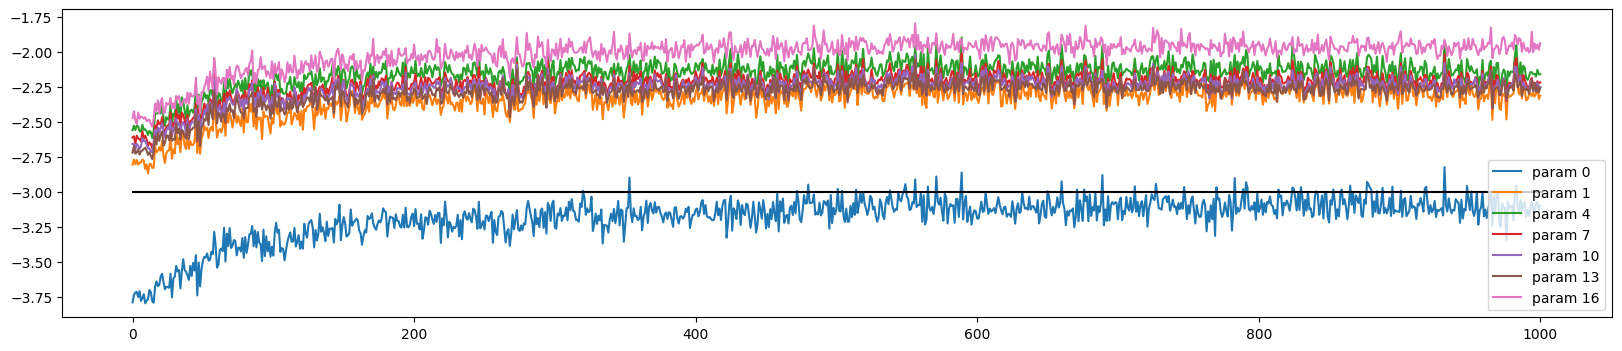

In [51]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


# Learnings from this part: 
- (Softmax being confidently wrong) The loss in step = 0 of the training should be closer to `-1 * torch.tensor(1/len(stoi)).float().log().item()` which is `3.2958` because without any training, the prob for any character should be the same. But instead, we often see much higher losses (in the example above, it was ~27). That's because the `logits` are randomly incorrect (i.e., network is erroneously but confidently wrong). __`logits` at init should be even across all classes__. Studying the `logits = b + W*tanh(h)` formula, we see that:
    - If `b` is initialized to non-zero values, then that can drive up loss. Solution - start `b` at zero. e.g., `b = torch.zeros(len(stoi))`
    - If `W` is initialized to larger absolute values, then that can also drive up loss. Solution - start `W` very close to 0. `W = torch.randn((hidden_units,len(stoi)), generator=g) * 0.01`. You don't want to set W to `0` because that can cause issues.
    - Another sign that you have this issue - you get a _hockey stick_ loss curve. That suggests that you have a very high loss in the beginning that rapidly decays (i.e., the network is falsely overconfident about predictions based on init values. 
- (`tanh` being saturated at init) The second challenge from random initialization is the `tanh` activation in the hidden layer. 
    - `tanh` is a squashing function - very large or small inputs will get pushed to `-1` or `+1` and because the backprop on a `tanh` is a `(1-tanh**2) * out.grad`, very large values simply have the effect of killing the backward prop of the gradient. 
    - In fact, it might even happen that for a given set of training examples, some `tanh` neurons (or other non-linear activation functions that have a flat part - like `ReLU`, `eLU`, `sigmoid`, etc.) don't back-prop gradient at all and are considered _dead neurons_. 
    - The way to diagnose this is to look at the distribution of the `tanh` activation values and see how often it is close to `-1/+1`

# Future topics to be covered:
* Other types of normalization (layer normalization, etc.) 
* convolution layers